[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-4/parallelization.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239934-lesson-1-parallelization)

# Parallel node execution

## Review

In module 3, we went in-depth on `human-in-the loop`, showing 3 common use-cases:

(1) `Approval` - We can interrupt our agent, surface state to a user, and allow the user to accept an action

(2) `Debugging` - We can rewind the graph to reproduce or avoid issues

(3) `Editing` - You can modify the state 

## Goals

This module will build on `human-in-the-loop` as well as the `memory` concepts discussed in module 2.

We will dive into `multi-agent` workflows and build up to a multi-agent research assistant that ties together all of the modules from this course.

To build this multi-agent research assistant, we'll first discuss a few LangGraph controllability topics.

We'll start with [parallelization](https://docs.langchain.com/oss/python/langgraph/how-tos/graph-api#create-branches).

## Fan out and fan in

Let's build a simple linear graph that over-writes the state at each step.

In [1]:
%%capture --no-stderr
%pip install -U  langgraph langgraph_tavily wikipedia langchain_openai langchain_community langgraph_sdk

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [16]:
from dotenv import load_dotenv
load_dotenv(dotenv_path="C:/Users/riyaa/Documents/code/mat496/langgraphmod4/studio/.env", override=True) #path to my env folder

True

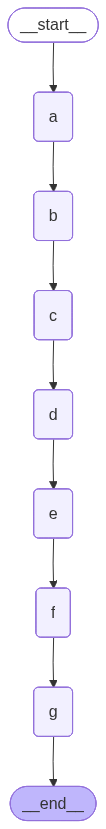

In [2]:
from IPython.display import Image, display

from typing import Any, List
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END

class State(TypedDict):
    # Note, no reducer function. 
    state: List[str]

class ReturnNodeValue:
    def __init__(self, node_secret: str):
        self._value = node_secret

    def __call__(self, state: State) -> Any:
        print(f"Adding {self._value} to {state['state']}")
        return {"state": [self._value]}

# Add nodes
builder = StateGraph(State)

# Initialize each node with node_secret 
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))
builder.add_node("e", ReturnNodeValue("I'm E"))
builder.add_node("f", ReturnNodeValue("I'm F"))
builder.add_node("g", ReturnNodeValue("I'm G"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("b", "c")
builder.add_edge("c", "d")
builder.add_edge("d", "e")
builder.add_edge("e", "f")
builder.add_edge("f", "g")
builder.add_edge("g", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

We over-write state, as expected.

In [3]:
graph.invoke({"state": []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm B"]
Adding I'm D to ["I'm C"]
Adding I'm E to ["I'm D"]
Adding I'm F to ["I'm E"]
Adding I'm G to ["I'm F"]


{'state': ["I'm G"]}

Now, let's run `b` and `c` in parallel. 

And then run `d`.

We can do this easily with fan-out from `a` to `b` and `c`, and then fan-in to `d`.

The the state updates are applied at the end of each step.

Let's run it.

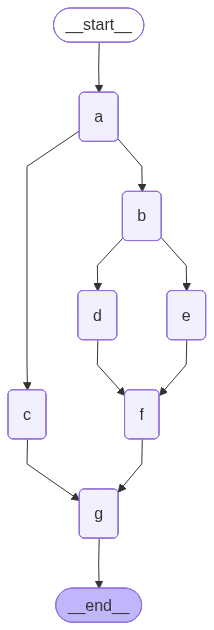

In [4]:
builder = StateGraph(State)

# Initialize each node with node_secret 
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))
builder.add_node("e", ReturnNodeValue("I'm E"))
builder.add_node("f", ReturnNodeValue("I'm F"))
builder.add_node("g", ReturnNodeValue("I'm G"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("b", "e")
builder.add_edge("d", "f")
builder.add_edge("e", "f")
builder.add_edge("f", "g")
builder.add_edge("c", "g")
builder.add_edge("g", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

**We see an error**! 

This is because both `b` and `c` are writing to the same state key / channel in the same step. 

In [5]:
from langgraph.errors import InvalidUpdateError
try:
    graph.invoke({"state": []})
except InvalidUpdateError as e:
    print(f"An error occurred: {e}")

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
An error occurred: At key 'state': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE


When using fan out, we need to be sure that we are using a reducer if steps are writing to the same the channel / key. 

As we touched on in Module 2, `operator.add` is a function from Python's built-in operator module.

When `operator.add` is applied to lists, it performs list concatenation.

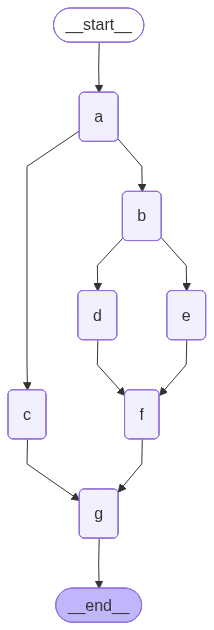

In [6]:
import operator
from typing import Annotated

class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    state: Annotated[list, operator.add]

# Add nodes
builder = StateGraph(State)

# Initialize each node with node_secret 
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))
builder.add_node("e", ReturnNodeValue("I'm E"))
builder.add_node("f", ReturnNodeValue("I'm F"))
builder.add_node("g", ReturnNodeValue("I'm G"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("b", "e")
builder.add_edge("d", "f")
builder.add_edge("e", "f")
builder.add_edge("f", "g")
builder.add_edge("c", "g")
builder.add_edge("g", END)
graph = builder.compile()


display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
graph.invoke({"state": []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm D to ["I'm A", "I'm B", "I'm C"]
Adding I'm G to ["I'm A", "I'm B", "I'm C"]
Adding I'm E to ["I'm A", "I'm B", "I'm C"]
Adding I'm F to ["I'm A", "I'm B", "I'm C", "I'm D", "I'm E", "I'm G"]
Adding I'm G to ["I'm A", "I'm B", "I'm C", "I'm D", "I'm E", "I'm G", "I'm F"]


{'state': ["I'm A",
  "I'm B",
  "I'm C",
  "I'm D",
  "I'm E",
  "I'm G",
  "I'm F",
  "I'm G"]}

Now we see that we append to state for the updates made in parallel by `b` and `c`.

## Waiting for nodes to finish

Now, lets consider a case where one parallel path has more steps than the other one.

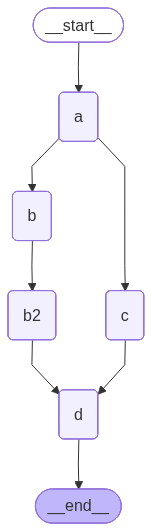

In [10]:
builder = StateGraph(State)

# Initialize each node with node_secret 
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("b2", ReturnNodeValue("I'm B2"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "b2")
builder.add_edge(["b2", "c"], "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In this case, `b`, `b2`, and `c` are all part of the same step.

The graph will wait for all of these to be completed before proceeding to step `d`. 

In [11]:
graph.invoke({"state": []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm B2 to ["I'm A", "I'm B", "I'm C"]
Adding I'm D to ["I'm A", "I'm B", "I'm B2", "I'm C"]


{'state': ["I'm A", "I'm B", "I'm B2", "I'm C", "I'm D"]}

## Setting the order of state updates

However, within each step we don't have specific control over the order of the state updates!

In simple terms, it is a deterministic order determined by LangGraph based upon graph topology that **we do not control**. 

Above, we see that `c` is added before `b2`.

However, we can use a custom reducer to customize this e.g., sort state updates.

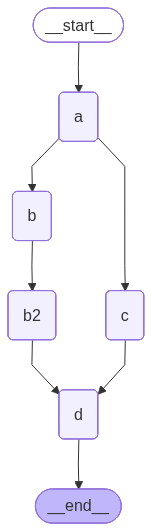

In [12]:
def sorting_reducer(left, right):
    """ Combines and sorts the values in a list"""
    if not isinstance(left, list):
        left = [left]

    if not isinstance(right, list):
        right = [right]
    
    return sorted(left + right, reverse=False)

class State(TypedDict):
    # sorting_reducer will sort the values in state
    state: Annotated[list, sorting_reducer]

# Add nodes
builder = StateGraph(State)

# Initialize each node with node_secret 
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("b2", ReturnNodeValue("I'm B2"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "b2")
builder.add_edge(["b2", "c"], "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:
graph.invoke({"state": []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm B2 to ["I'm A", "I'm B", "I'm C"]
Adding I'm D to ["I'm A", "I'm B", "I'm B2", "I'm C"]


{'state': ["I'm A", "I'm B", "I'm B2", "I'm C", "I'm D"]}

Now, the reducer sorts the updated state values!

The `sorting_reducer` example sorts all values globally. We can also: 

1. Write outputs to a separate field in the state during the parallel step
2. Use a "sink" node after the parallel step to combine and order those outputs
3. Clear the temporary field after combining

<!-- See the [~docs~](https://langchain-ai.github.io/langgraph/how-tos/branching/#stable-sorting) [docs](https://docs.langchain.com/oss/python/langgraph/how-tos/graph-api#create-branches) for more details.-->


## Working with LLMs

Now, lets add a realistic example! 

We want to gather context from two external sources (Wikipedia and Web-Search) and have an LLM answer a question.

In [14]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash", 
    temperature=0.7,
)

In [53]:
class State(TypedDict):
    question: str
    answer: str
    context: Annotated[list, operator.add]

You can try different web search tools. [Tavily](https://tavily.com/) is one nice option to consider, but ensure your `TAVILY_API_KEY` is set.

In [15]:
import os, getpass
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")
_set_env("TAVILY_API_KEY") #api key already in .env so this is not needed

In [19]:
pip install langchain_community


  Using cached langchain_classic-1.0.0-py3-none-any.whl.metadata (3.9 kB)
  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Using cached dataclasses_json-0.6.7-py3-none-any.whl.metadata (25 kB)
  Using cached pydantic_settings-2.11.0-py3-none-any.whl.metadata (3.4 kB)
  Using cached httpx_sse-0.4.3-py3-none-any.whl.metadata (9.7 kB)
  Using cached marshmallow-3.26.1-py3-none-any.whl.metadata (7.3 kB)
  Using cached typing_inspect-0.9.0-py3-none-any.whl.metadata (1.5 kB)
  Using cached langchain_text_splitters-1.0.0-py3-none-any.whl.metadata (2.6 kB)
  Using cached typing_inspection-0.4.2-py3-none-any.whl.metadata (2.6 kB)
   ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
   ---------------------------- ----------- 1.8/2.5 MB 11.8 MB/s eta 0:00:01
   ---------------------------------------- 2.5/2.5 MB 11.3 MB/s eta 0:00:00
Using cached dataclasses_json-0.6.7-py3-none-any.whl (28 kB)
Using cached httpx_sse-0.4.3-py3-none-any.whl (9.0 kB)
Using cached 

In [21]:
!pip install langchain_tavily

  Using cached aiohappyeyeballs-2.6.1-py3-none-any.whl.metadata (5.9 kB)
  Using cached aiosignal-1.4.0-py3-none-any.whl.metadata (3.7 kB)
Using cached aiohappyeyeballs-2.6.1-py3-none-any.whl (15 kB)
Using cached aiosignal-1.4.0-py3-none-any.whl (7.5 kB)

  Attempting uninstall: aiosignal

    Found existing installation: aiosignal 1.2.0

    Uninstalling aiosignal-1.2.0:

      Successfully uninstalled aiosignal-1.2.0

  Attempting uninstall: aiohappyeyeballs

    Found existing installation: aiohappyeyeballs 2.4.4

    Uninstalling aiohappyeyeballs-2.4.4:

      Successfully uninstalled aiohappyeyeballs-2.4.4

  Attempting uninstall: aiohttp

    Found existing installation: aiohttp 3.11.10

    Uninstalling aiohttp-3.11.10:

      Successfully uninstalled aiohttp-3.11.10

   ----------- ---------------------------- 2/7 [aiohttp]
   ----------- ---------------------------- 2/7 [aiohttp]
  Attempting uninstall: langgraph-prebuilt
   ----------- ---------------------------- 2/7 [aiohtt

In [23]:
!pip install langchain_core

In [38]:
!pip install wikipedia

^C
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11704 sha256=fca6e19b79299e2d83f8052ff8011574d4e981e91678fd6e6d4403db4209102e
  Stored in directory: c:\users\riyaa\appdata\local\pip\cache\wheels\79\1d\c8\b64e19423cc5a2a339450ea5d145e7c8eb3d4aa2b150cde33b
Successfully built wikipedia


  DEPRECATION: Building 'wikipedia' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'wikipedia'. Discussion can be found at https://github.com/pypa/pip/issues/6334


In [54]:
!pip install newsapi-python

In [79]:
!pip install xmltodict

  Using cached xmltodict-1.0.2-py3-none-any.whl.metadata (15 kB)
Using cached xmltodict-1.0.2-py3-none-any.whl (13 kB)


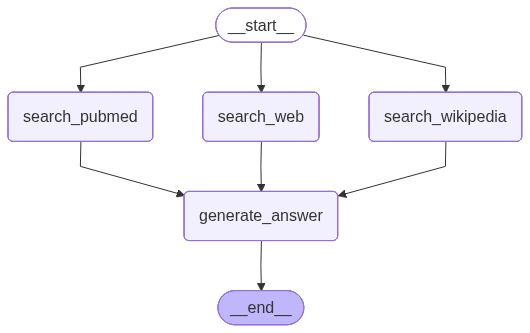

In [78]:
from langchain_core.messages import HumanMessage, SystemMessage

from langchain_community.document_loaders import WikipediaLoader
from langchain_tavily import TavilySearch  # updated since filming

def search_web(state):
    
    """ Retrieve docs from web search """

    # Search
    tavily_search = TavilySearch(max_results=3)
    data = tavily_search.invoke({"query": state['question']})
    search_docs = data.get("results", data)

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}">\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

def search_wikipedia(state):
    
    """ Retrieve docs from wikipedia """

    # Search
    search_docs = WikipediaLoader(query=state['question'], 
                                  load_max_docs=2).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}">\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

from langchain_community.document_loaders import NewsURLLoader

'''def search_news(state):
    """ Retrieve recent news articles """
    from newsapi import NewsApiClient  
    
    newsapi = NewsApiClient(api_key='YOUR_API_KEY')
    articles = newsapi.get_everything(q=state['question'], 
                                     language='en',
                                     sort_by='relevancy',
                                     page_size=3)
    
    # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{article["source"]["name"]}" url="{article["url"]}">\n{article["title"]}\n{article.get("description", "")}\n</Document>'
            for article in articles['articles']
        ]
    )
    return {"context": [formatted_search_docs]}'''

from langchain_community.document_loaders import PubMedLoader

def search_pubmed(state):
    """ Retrieve medical/scientific papers from PubMed """
    search_docs = PubMedLoader(query=state['question'], load_max_docs=3).load()
    
    # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="PubMed" uid="{doc.metadata.get("uid", "")}">\n{doc.page_content[:1000]}\n</Document>'
            for doc in search_docs
        ]
    )
    return {"context": [formatted_search_docs]}

def generate_answer(state):
    
    """ Node to answer a question """

    # Get state
    context = state["context"]
    question = state["question"]

    # Template
    answer_template = """Answer the question {question} using this context: {context}"""
    answer_instructions = answer_template.format(question=question, 
                                                       context=context)    
    
    # Answer
    answer = llm.invoke([SystemMessage(content=answer_instructions)]+[HumanMessage(content=f"Answer the question.")])
      
    # Append it to state
    return {"answer": answer}



# Add nodes
builder = StateGraph(State)

# Initialize each node with node_secret 
builder.add_node("search_web",search_web)
builder.add_node("search_wikipedia", search_wikipedia)
builder.add_node("generate_answer", generate_answer)
builder.add_node("search_pubmed", search_pubmed)

# Flow
builder.add_edge(START, "search_wikipedia")
builder.add_edge(START, "search_web")
builder.add_edge(START, "search_pubmed")
builder.add_edge("search_wikipedia", "generate_answer")
builder.add_edge("search_web", "generate_answer")
builder.add_edge("search_pubmed", "generate_answer")
builder.add_edge("generate_answer", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))


In [74]:
result = graph.invoke({"question": "How were Nvidia's Q2 2025 earnings"})
result['answer'].content

"Nvidia's Q2 2025 earnings exceeded expectations. The company reported an EPS of $1.04, beating the forecast of $1.01. Revenue also exceeded expectations. Adjusted earnings per share were reported as $1.05, also beating analyst estimates."

## Using with LangGraph API

**⚠️ Notice**

Since filming these videos, we've updated Studio so that it can now be run locally and accessed through your browser. This is the preferred way to run Studio instead of using the Desktop App shown in the video. It is now called _LangSmith Studio_ instead of _LangGraph Studio_. Detailed setup instructions are available in the "Getting Setup" guide at the start of the course. You can find a description of Studio [here](https://docs.langchain.com/langsmith/studio), and specific details for local deployment [here](https://docs.langchain.com/langsmith/quick-start-studio#local-development-server).  
To start the local development server, run the following command in your terminal in the `/studio` directory in this module:

```
langgraph dev
```

You should see the following output:
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

Open your browser and navigate to the **Studio UI** URL shown above.

In [18]:
if 'google.colab' in str(get_ipython()):
    raise Exception("Unfortunately LangSmith Studio is currently not supported on Google Colab")

In [71]:
from langgraph_sdk import get_client
client = get_client(url="http://127.0.0.1:2024")

In [75]:
from langgraph_sdk import get_client
client = get_client(url="http://127.0.0.1:2024")

In [72]:
thread = await client.threads.create()
input_question = {"question": "How were Nvidia Q2 2025 earnings?"}
async for event in client.runs.stream(thread["thread_id"], 
                                      assistant_id="parallelization", 
                                      input=input_question, 
                                      stream_mode="values"):
    # Check if answer has been added to state  
    if event.data is not None:
        answer = event.data.get('answer', None)
        if answer:
            print(answer['content'])

I am sorry, but I do not have the ability to answer the question "How were Nvidia Q2 2025 earnings?" as I do not have access to the internet to get the latest financial data.
Nvidia's Q2 2025 earnings were strong, exceeding expectations.

Here's a breakdown:

*   **EPS:** Reported at $1.04, beating the forecast of $1.01.
*   **Revenue:** Reached $46.74 billion, surpassing both analyst estimates and the previous quarter's record.


In [80]:
thread = await client.threads.create()
input_question = {"question": "What are the health benefits of intermittent fasting?"}
async for event in client.runs.stream(thread["thread_id"], 
                                      assistant_id="parallelization", 
                                      input=input_question, 
                                      stream_mode="values"):
    # Check if answer has been added to state  
    if event.data is not None:
        answer = event.data.get('answer', None)
        if answer:
            print(answer['content'])

Intermittent fasting (IF) may offer several health benefits:

*   **Weight Loss:** IF can be used as a method for weight loss.
*   **Heart Health:** IF may benefit heart health.
*   **Metabolic Health:** IF may improve metabolic outcomes in overweight or obese adults.
*   **Reduce Inflammation:** IF may reduce inflammation.
*   **Cell Repair:** IF may improve cell repair processes.
*   **Extended Longevity:** IF may contribute to extended longevity.
*   **Counteracting Disease Conditions:** IF may counteract various disease conditions.
*   **Improve Blood Pressure, Lipid Profiles, and Glucose Regulation:** Time-restricted eating (TRE), a type of IF, has been shown to improve these markers.
*   **Improved Alertness, Mood, and Cognitive Performance:** Fasting may improve these aspects of mental health.
